<a href="https://colab.research.google.com/github/vijishmadhavan/App/blob/master/PoPd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install requrements
%%capture

!git clone https://github.com/vijishmadhavan/PoPd.git PoPd
!cd PoPd
!pip install -r colab_requirements.txt

In [1]:
#@title Import requrements
%%capture
import urllib.request
import PIL.Image
from PIL import Image
import requests
import fastai
from fastai.vision import *
from fastai.utils.mem import *
from fastai.vision import open_image, load_learner, image, torch
import numpy as np
from urllib.request import urlretrieve
from io import BytesIO
import numpy as np
import torchvision.transforms as T
from PIL import Image,ImageOps,ImageFilter
from io import BytesIO
import os

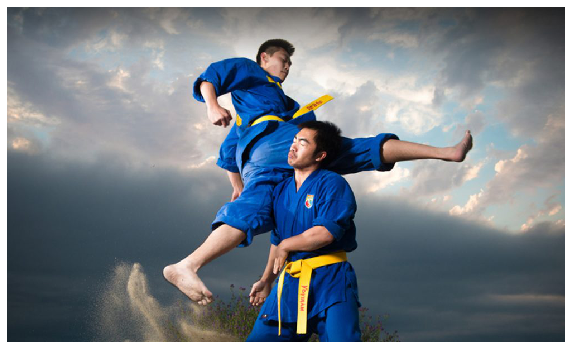

In [4]:
from PIL import Image
import PIL.Image
import fastai
from fastai.vision import *

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

MODEL_URL = "https://www.dropbox.com/s/05ong36r29h51ov/popd.pkl?dl=1"
urllib.request.urlretrieve(MODEL_URL, "popd.pkl")
path = Path(".")
learn=load_learner(path, 'popd.pkl')

url = 'https://cdn.chaohanoi.com/hanoi/2020/08/18155446/vovinam-vietnam-martial-art-1000x600.jpg' #@param {type:"string"}

response = requests.get(url)
img = PIL.Image.open(BytesIO(response.content)).convert("RGB")
img_t = T.ToTensor()(img)
img_fast = Image(img_t)
show_image(img_fast, figsize=(10,10), interpolation='nearest');
from PIL import Image

p,img_hr,b = learn.predict(img_fast)
x = np.minimum(np.maximum(image2np(img_hr.data*255), 0), 255).astype(np.uint8)
PIL_image = Image.fromarray(np.uint8(x)).convert('RGB')
size = img.size
im1 = PIL_image.resize(size)
membuf = BytesIO()
im1.save(membuf, format="png") 

from PIL import Image,ImageOps


im = Image.open(membuf)
im = im.convert('RGBA')

data = np.array(im)   # "data" is a height x width x 4 numpy array
red, green, blue, alpha = data.T # Temporarily unpack the bands for readability

# Replace white with red... (leaves alpha values alone...)
white_areas = (red == 0) & (blue == 0) & (green == 0)
data[..., :-1][white_areas.T] = (0,0,0) # Transpose back needed


#(15,22,32)
im2 = Image.fromarray(data)
im2 = PIL_image.resize(size)
membuf = BytesIO()
im2.save(membuf, format="png") 

def getNeighbours(i, j, n, m) :
    arr = []
    if i-1 >= 0 and j-1 >= 0 :
        arr.append((i-1, j-1))
    if i-1 >= 0 :
        arr.append((i-1, j))
    if i-1 >= 0 and j+1 < m :
        arr.append((i-1, j+1))
    if j+1 < m :
        arr.append((i, j+1))
    if i+1 < n and j+1 < m :
        arr.append((i+1, j+1))
    if i+1 < n :
        arr.append((i+1, j))
    if i+1 < n and j-1 >= 0 :
        arr.append((i+1, j-1))
    if j-1 >= 0 :
        arr.append((i, j-1))
    return arr


red =  (185, 39, 40)
yellow= (249, 223, 2) 
blue= (40, 96, 219)
grey = (53,55,57)
white = (255,255,255)


from PIL import Image, ImageFilter

def predict(red):
  img = Image.open(membuf)
  bitmap = img.load()
  n = img.size[0]
  m = img.size[1]
  stateMap = []
  for i in range(n):
    stateMap.append([False for j in range(m)])       

  queue = [(0, 0)]
  while queue:
    e = queue.pop(0)
    i = e[0]
    j = e[1]
    if not stateMap[i][j]:
      stateMap[i][j] = True
      color = int((bitmap[i, j][0] + bitmap[i, j][1] + bitmap[i, j][2])/3)
      if color > 100: # check the color of the pixel against athreshold
        bitmap[i, j] = red# fill light blue color #(135, 206, 250) (248, 238, 88)
        neigh = getNeighbours(i, j, n, m)
        for ne in neigh:
          queue.append(ne) # add neighbour pixels to the queue
#red (185, 39, 40)
# yellow (249, 223, 2) 
# blue (40, 96, 219)
  return img 

#Try Below colours
red

yellow

blue

grey 

white

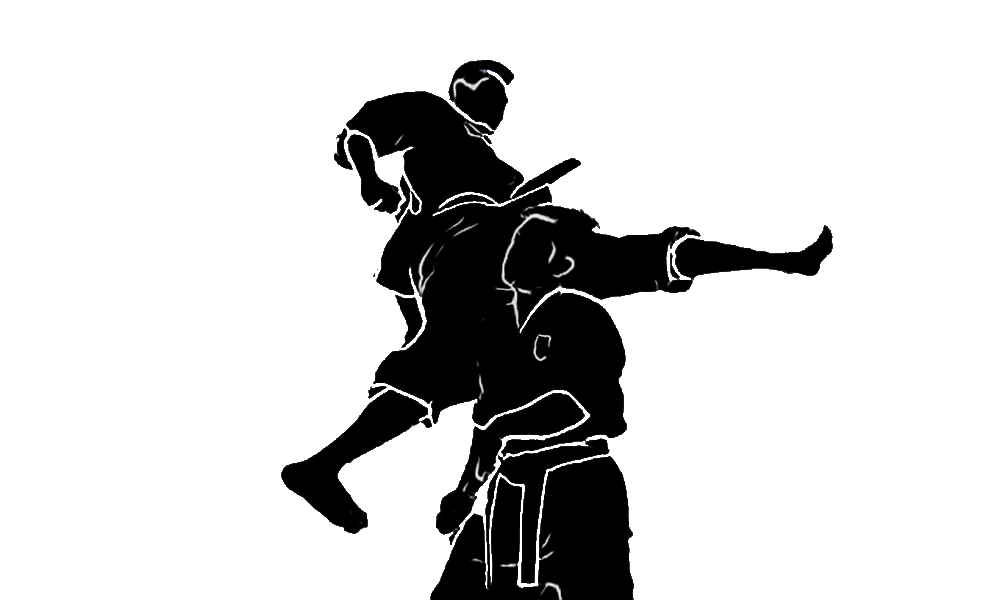

In [5]:
predict(white)